# Processamento de Linguagem Natural (PLN)
_Natural Language Processing (NLP) em Inglês_

## Análise de Sentimentos - Twitter

Identificar se o tweet é **racista/sexista** ou **não**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Ler dados

In [2]:
train = pd.read_csv('twitter/train.csv')
test = pd.read_csv('twitter/test.csv')

In [3]:
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')

Train Shape: (31962, 3)
Test Shape: (17197, 2)


In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
train['tweet'] = train['tweet'].str.lower() 
                        # deixar todas as strings em minusculo
                        # caso queira, dá pra deixar todas as strings em
                        # maiusculo usando train['tweet'].str.upper()

## Pré-processamento de Dados

### Tirar pontuações e caracteres especiais

In [6]:
# Expressão Regular
# r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
train['tweet'] = train['tweet'].apply(lambda x: \
                     re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", \
                            "", x))

In [7]:
def limpa_texto(data, col):
    """
    Tira Pontuações e Caracteres especiais recebendo um dataframe (data) 
    e uma coluna (col).
    """
    data[col] = data[col].str.lower() 
    data[col] = data[col].apply(lambda x: \
                     re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", \
                            "", x))

In [8]:
limpa_texto(test, 'tweet')

In [9]:
test.head()

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,white supremacists want everyone to see the ...
2,31965,safe ways to heal your acne altwaystoheal h...
3,31966,is the hp and the cursed child book up for res...
4,31967,3rd bihday to my amazing hilarious nephew el...


### Remover palavras comuns

In [10]:
palavras_comuns = stopwords.words('english')

In [11]:
len(palavras_comuns)

179

In [12]:
# dividir os tweets em listas de palavras para que possamos
# retirar as stopwords, que são palavras que não acrescentam
# significado a nossa avaliação.
[palavra for palavra in train['tweet'].str.split()[0] if palavra not in palavras_comuns]

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run']

In [13]:
def remove_palavras_comuns(data, col, lang):
    """
    Remove stopwords do texto.
    """
    palavras_comuns = stopwords.words(lang)
    lista_de_lista_de_palavras = data[col].str.split()
    
    for idx, _ in data.iterrows():
        data[col].at[idx] = [palavra for palavra in \
                             lista_de_lista_de_palavras[idx] \
                             if palavra not in palavras_comuns]

In [14]:
remove_palavras_comuns(test, 'tweet', 'english')

In [15]:
remove_palavras_comuns(train, 'tweet', 'english')

### Remover variações da mesma palavra

In [16]:
tira_variacao = WordNetLemmatizer()

In [17]:
# exemplo de uso
tira_variacao.lemmatize('went','v')

'go'

In [18]:
def tira_variacao_de_palavras(data, col):
    tira_variacao = WordNetLemmatizer()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [tira_variacao.lemmatize(palavra,'v') \
                             for palavra in data[col][idx]]

In [19]:
tira_variacao_de_palavras(train, 'tweet')

In [20]:
tira_variacao_de_palavras(test, 'tweet')

### Engenharia de Recursos (Feature Engineering ) 
#### Quantidade de palavras por tweet

In [21]:
train['palavras'] = train['tweet'].apply(len)

In [22]:
train['tweet']

0        [father, dysfunctional, selfish, drag, kid, dy...
1        [thank, lyft, credit, cant, use, cause, dont, ...
2                                        [bihday, majesty]
3                      [model, love, u, take, u, time, ur]
4                        [factsguide, society, motivation]
                               ...                        
31957                                    [eat, isz, youuu]
31958    [see, nina, turner, airwaves, try, wrap, mantl...
31959    [listen, sad, songs, monday, morning, otw, wor...
31960    [sikh, temple, vandalise, calgary, wso, condem...
31961                                      [thank, follow]
Name: tweet, Length: 31962, dtype: object

In [23]:
test['palavras'] = test['tweet'].apply(len)

In [24]:
train.head()

,id,label,tweet,palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3


## Análise Exploratória de Dados (AED)

### Distribuição das quantidades de palavras por "label"

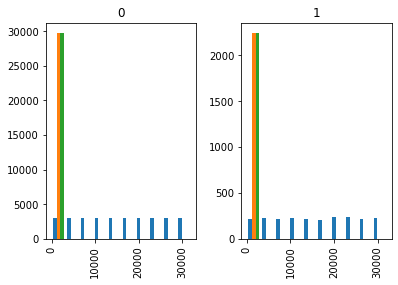

In [27]:
train.hist(column=['palavras'], by='label')
plt.show()

### Quantidade de cada "label"

C:\Users\Leonardo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

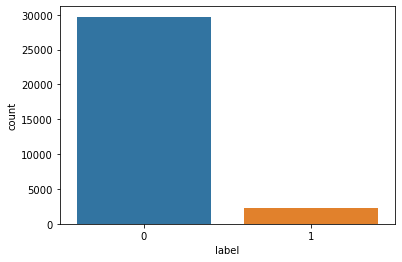

In [28]:
sns.countplot('label', data=train)

### Palavras frequêntes

#### Averiguar palavras mais frequêntes classificadas como "racistas ou sexistas"

In [30]:
train.head()

,id,label,tweet,palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3


In [32]:
train.loc[train['label']==1]['tweet']

13       [cnn, call, michigan, middle, school, build, w...
14       [comment, australia, opkillingbay, seashepherd...
17                                        [retweet, agree]
23                              [lumpy, say, prove, lumpy]
34       [unbelievable, 21st, century, wed, need, somet...
                               ...                        
31934       [lady, ban, kentucky, mall, jcpenny, kentucky]
31946    [omfg, im, offend, im, mailbox, im, proud, mai...
31947    [dont, ball, hashtag, say, weasel, away, lumpy...
31948            [make, ask, anybody, god, oh, thank, god]
31960    [sikh, temple, vandalise, calgary, wso, condem...
Name: tweet, Length: 2242, dtype: object

In [33]:
# transformar tudo em uma só lista de palavras
lista_de_listas = train.loc[train['label']==1]['tweet']
palavras = [palavra for lista in lista_de_listas for palavra in lista]

In [34]:
len(palavras)

18596

In [35]:
import collections # vai nos auxiliar a contar as palavras mais frequentes de 
                    # maneira mais simples

In [36]:
def gera_freq_de_palavras(lista):
    return collections.Counter(lista)

In [38]:
freq_palavras = gera_freq_de_palavras(palavras)

In [39]:
len(freq_palavras)

5285

In [40]:
# gerar um dataframe de palavras e frequencias
lista_de_palavras = []
lista_de_frequencias =[]

for palavra, frequencia in freq_palavras.items():
    lista_de_palavras.append(palavra)
    lista_de_frequencias.append(frequencia)

In [42]:
data_freq = pd.DataFrame({'palavra': lista_de_palavras, 
                          'frequencia': lista_de_frequencias})

In [44]:
data_freq.sort_values('frequencia', ascending=False) # ascending=False significa 
                                                    # que eu vou mostrar menor valor
                                                    # para o maior valor

,palavra,frequencia
49,amp,283
69,trump,216
33,white,153
98,libtard,149
65,black,146
...,...,...
2835,antijewish,1
2838,override,1
2839,journalists,1
2840,integrity,1


### Nuvem de Palavras 

### Retornar para formato de texto

###  Solucionar problema de desequilibrio dos dados

## Treinar Modelo

## Avaliar Performance do Modelo

## Submissão

Fontes (em inglês):
* http://bit.ly/NLP-Twitter
* http://bit.ly/NLP-Twitter-Competition